### Importing the libraries:

In [1]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import os
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import InputLayer, Conv1D, Flatten, MaxPooling1D, UpSampling1D, Reshape
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.utils import shuffle
import plotly.express as px

from numpy import mean
from numpy import std
from numpy import dstack
from keras.utils import to_categorical

 chenge this function to convert sequences which has 3 feature input and categorical_class as output


### function to create sequences:

In [3]:
def to_sequences(df, seq_size=128, seq_stride=128, feature='CURRENT|6', y_type='wear_class', mix='OFF', current_values='current_values', anomaly_or_not='anomaly_or_not'):
    #feature_cols = ['CURRENT|6', 'CURRENT|1', 'CURRENT|2']
    x1_values = []
    x2_values = []
    x3_values = []
    y_values = []
    file_index = []
    is_anomaly = []
    wear_class = []

    for index, data in enumerate(df['CURRENT|6']):
      for i in range(0,len(data)-seq_size,seq_stride):
          x1_values.append(data[i:(i+seq_size)])
          #y_values.append(data[i+seq_size])
          file_index.append(df.iloc[index].file_no)
          is_anomaly.append(df.iloc[index][anomaly_or_not])
          wear_class.append(df.iloc[index]['wear_class'])

    for index, data in enumerate(df['CURRENT|1']):
      for i in range(0,len(data)-seq_size,seq_stride):
          x2_values.append(data[i:(i+seq_size)])

    for index, data in enumerate(df['CURRENT|2']):
      for i in range(0,len(data)-seq_size,seq_stride):
          x3_values.append(data[i:(i+seq_size)])

    
    if mix=='ON':
      x1_values, x2_values, x3_values, file_index, wear_class, is_anomaly = shuffle(x1_values, x2_values, x3_values, file_index, wear_class, is_anomaly, random_state=1)

    seq_df = pd.DataFrame({
        'file_no':file_index,
        'anomaly_or_not':is_anomaly,
        'wear_class': wear_class,
        'CURRENT|6':x1_values,
        'CURRENT|1':x2_values,
        'CURRENT|2':x3_values
    })
    if y_type == 'wear_class':
      y_values = wear_class
    elif y_type == anomaly_or_not:
      y_values = is_anomaly

    #x_list = list()
    #x_list.append(x1_values, x2_values, x3_values)
    x_3d = np.dstack([x1_values, x2_values, x3_values])
    x_array = x_3d #np.asarray(x_values).astype('float32')
    y_array = to_categorical(y_values)
    #x_array = np.reshape(x_array, (x_array.shape[0],x_array.shape[1],1))
    return seq_df, x_array, y_array

In [4]:
def to_sequences_1_feature(df, seq_size=128, seq_stride=128, y_type='wear_class', feature='CURRENT|6', mix='OFF', current_values='current_values', anomaly_or_not='anomaly_or_not'):
    #feature_cols = ['CURRENT|6', 'CURRENT|1', 'CURRENT|2']
    x1_values = []
    #x2_values = []
    #x3_values = []
    y_values = []
    file_index = []
    is_anomaly = []
    wear_class = []

    for index, data in enumerate(df[feature]):
      for i in range(0,len(data)-seq_size,seq_stride):
          x1_values.append(data[i:(i+seq_size)])
          #y_values.append(data[i+seq_size])
          file_index.append(df.iloc[index].file_no)
          is_anomaly.append(df.iloc[index][anomaly_or_not])
          wear_class.append(df.iloc[index]['wear_class'])
    
    if mix=='ON':
      x1_values, file_index, wear_class, is_anomaly = shuffle(x1_values, file_index, wear_class, is_anomaly, random_state=1)

    seq_df = pd.DataFrame({
        'file_no':file_index,
        'anomaly_or_not':is_anomaly,
        'wear_class': wear_class,
        feature:x1_values,
        #'CURRENT|1':x2_values,
        #'CURRENT|2':x3_values
    })
    if y_type == 'wear_class':
      y_values = wear_class
    elif y_type == anomaly_or_not:
      y_values = is_anomaly

    #x_list = list()
    #x_list.append(x1_values, x2_values, x3_values)
    x_3d = np.dstack([x1_values])
    x_array = x_3d #np.asarray(x_values).astype('float32')
    y_array = to_categorical(y_values)
    #x_array = np.reshape(x_array, (x_array.shape[0],x_array.shape[1],1))
    return seq_df, x_array, y_array

### function to plot loss and accuracy

In [5]:
def plot_loss(history):
  plt.plot(history['loss'], label='Training loss');
  plt.plot(history['val_loss'], label='Validation loss');
  plt.xlabel("Epoch")
  plt.ylabel("loss")
  plt.legend()
  return

In [6]:
def plot_accuracy(history):
  plt.plot(history['accuracy'], label='Accuracy');
  plt.plot(history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel("Epoch")
  plt.ylabel("accuracy")
  plt.legend()
  return

## Before Transfer Learning:

In [10]:
balanced_df = pd.read_csv('/content/drive/MyDrive/wbk/tool_wear_data/balanced_tool_wear_current_data.csv', 
                          dtype={'file_no':int, 'tool':int, 'tool_diameter':int, 'damage_teeth':str, 'wear_class':int, 'is_anomaly':bool})

balanced_df = balanced_df[balanced_df.file_no.isin([1,5,9])] #1,2,3,4,9,10,11,12

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(balanced_df[['CURRENT|1', 'CURRENT|2','CURRENT|6' ]].to_numpy())
balanced_df[['CURRENT|1', 'CURRENT|2','CURRENT|6']] = df_scaled.tolist()

balanced_df_list = (balanced_df.groupby(['file_no','tool', 'tool_diameter','damage_teeth','is_anomaly','wear_class']).
                    agg({'CURRENT|6': lambda x: x.tolist(),'CURRENT|1': lambda y: y.tolist(),'CURRENT|2': lambda z: z.tolist()}).
                    reset_index())
window_size = 300
df_seq, X, y = to_sequences(balanced_df_list, window_size, 10, mix='ON', y_type='is_anomaly', anomaly_or_not='is_anomaly') #,feature='CURRENT|6'
print(X.shape, y.shape)
print('----')
#print_anomaly_stats(df_seq, cur_val_col='CURRENT|6');
df = df_seq.reset_index()
print('total_sequences: ',df.groupby('index').size().count())
print(df.groupby(['index', 'wear_class'])['wear_class'].count().groupby('wear_class').count()) 

train_test_split = 0.8  # 80% test train split ratio
to_split_at = int(train_test_split*X.shape[0])
df_seq_train, X_train1, y_train1 = df_seq[:to_split_at], X[:to_split_at], y[:to_split_at]
print(X_train1.shape, y_train1.shape)
df_seq_test, X_test1, y_test1 = df_seq[to_split_at:], X[to_split_at:], y[to_split_at:]
print(X_test1.shape, y_test1.shape)
print('------')
df = df_seq_train.reset_index()
print('total_train_sequences: ',df.groupby('index').size().count())
print(df.groupby(['index', 'wear_class'])['wear_class'].count().groupby('wear_class').count())
print('------')
df = df_seq_test.reset_index()
print('total_test_sequences: ',df.groupby('index').size().count())
print(df.groupby(['index', 'wear_class'])['wear_class'].count().groupby('wear_class').count())

trainX, trainy, testX, testy = X_train1, y_train1, X_test1, y_test1
verbose, epochs, batch_size = 1, 10, 100
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

lstm_autoencoder = keras.Sequential()
# Encoder
lstm_autoencoder.add(LSTM(32, activation='tanh', input_shape=(n_timesteps, n_features), return_sequences=True)) #'tanh'
lstm_autoencoder.add(LSTM(16, activation='tanh', return_sequences=True))
lstm_autoencoder.add(LSTM(8, activation='tanh', return_sequences=False))
lstm_autoencoder.add(RepeatVector(n_timesteps))
# Decoder
lstm_autoencoder.add(LSTM(8, activation='tanh', return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation='tanh', return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation='tanh', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.compile(optimizer='adam', #1e-2, 
            loss='mse',
            metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_autoencoder.summary()
# fit_network
lstm_autoencoder_history = lstm_autoencoder.fit(trainX, trainX, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.1).history
# evaluate model
_, accuracy = lstm_autoencoder.evaluate(testX, testX, batch_size=batch_size, verbose=1)

(38583, 300, 3) (38583, 1)
----
total_sequences:  38583
wear_class
0    38583
Name: wear_class, dtype: int64
(30866, 300, 3) (30866, 1)
(7717, 300, 3) (7717, 1)
------
total_train_sequences:  30866
wear_class
0    30866
Name: wear_class, dtype: int64
------
total_test_sequences:  7717
wear_class
0    7717
Name: wear_class, dtype: int64
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 300, 32)           4608      
                                                                 
 lstm_19 (LSTM)              (None, 300, 16)           3136      
                                                                 
 lstm_20 (LSTM)              (None, 8)                 800       
                                                                 
 repeat_vector_3 (RepeatVect  (None, 300, 8)           0         
 or)                                          

In [11]:
save_dir = '/content/drive/MyDrive/saved_model/'
this_model_name = 'final_LSTM_AE' #100_10_f5678_minMaxScl_1c_1l_3x_2y_tlwr_v1
lstm_autoencoder.save(save_dir+this_model_name);

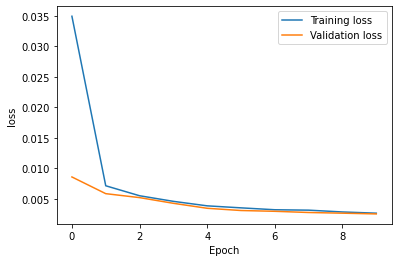

In [12]:
plot_loss(lstm_autoencoder_history)

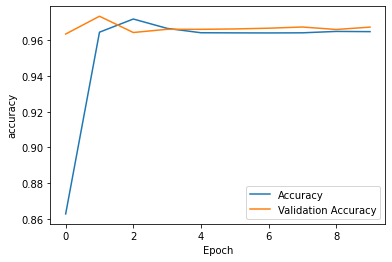

In [13]:
plot_accuracy(lstm_autoencoder_history)

965/965 [==============================] - 110s 112ms/step


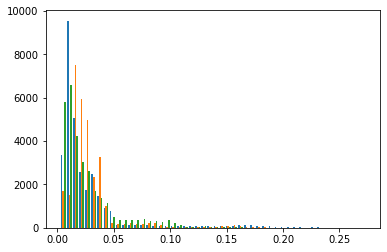

In [14]:
trainPredict = lstm_autoencoder.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
plt.hist(trainMAE, bins=50);

242/242 [==============================] - 26s 109ms/step


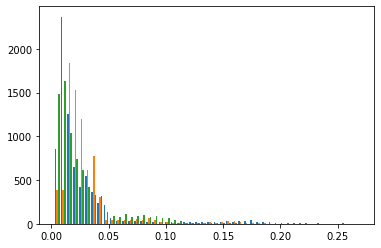

In [15]:
testPredict = lstm_autoencoder.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1);
plt.hist(testMAE, bins=50);

<ipython-input-16-a9c9bf029c5e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['pred_current'] = [x for x in np.squeeze(reconstructed)]
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
<ipython-input-16-a9c9bf029c5e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

[[26036  4830]
 [    0     0]]
              precision    recall  f1-score   support

       False       1.00      0.84      0.92     30866
        True       0.00      0.00      0.00         0

    accuracy                           0.84     30866
   macro avg       0.50      0.42      0.46     30866
weighted avg       1.00      0.84      0.92     30866



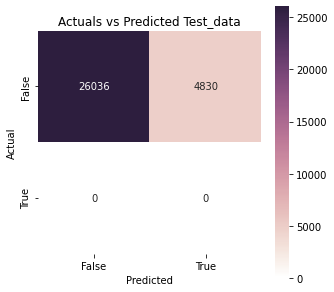

In [16]:
max_trainMAE_1 = 0.03
max_trainMAE_2 = 0.03
max_trainMAE_3 = 0.03

df_result, original, MAE, reconstructed = df_seq_train, trainX, trainMAE, trainPredict
threshold_1, threshold_2, threshold_3 = max_trainMAE_1, max_trainMAE_2, max_trainMAE_3

df_result['pred_current'] = [x for x in np.squeeze(reconstructed)]
df_result[['MAE_1', 'MAE_2', 'MAE_3']] = MAE #MAE
# [x for x in np.repeat(threshold,df_result.shape[0],axis=0)]
df_result['threshold_1'] = threshold_1 
df_result['threshold_2'] = threshold_2
df_result['threshold_3'] = threshold_3
df_result['pred_anomaly'] = (df_result['MAE_1'] > df_result['threshold_1']) & (df_result['MAE_2'] > df_result['threshold_2']) & df_result['MAE_3'] > df_result['threshold_3']
df_result['anomaly_or_not'] = df_result['anomaly_or_not'].astype('bool')

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
org = df_result.anomaly_or_not #df_seq_train.wear_class
pred = df_result.pred_anomaly
data = confusion_matrix(org,pred)
print(data)
print(classification_report(org, pred))
df_cm = pd.DataFrame(data, columns=['False','True'], index = ['False','True']) #, columns=np.unique(org), index = np.unique(org))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(df_cm, cbar=True, annot=True, cmap=cmap, square=True, fmt='.0f', annot_kws={'size': 20})
plt.title('Actuals vs Predicted Test_data')
plt.show()

### Confusion matrix: Train

In [ ]:
trainPredict1 = model_1.predict(X_train1)
df_seq_train['pred']  = np.argmax(trainPredict1, axis=1)
org = df_seq_train.anomaly_or_not #df_seq_train.wear_class
pred = df_seq_train.pred

data = confusion_matrix(org,pred)
print(data)
print(classification_report(org, pred))

df_cm = pd.DataFrame(data, columns=np.unique(org), index = np.unique(org))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(df_cm, cbar=True, annot=True, cmap=cmap, square=True, fmt='.0f',
            annot_kws={'size': 20})
plt.title('Actuals vs Predicted Train_data')
plt.show()

### Confusion matrix: Test

In [ ]:
testPredict1 = model_1.predict(X_test1)
df_seq_test['pred']  = np.argmax(testPredict1, axis=1)
org = df_seq_test.anomaly_or_not #df_seq_train.wear_class
pred = df_seq_test.pred
data = confusion_matrix(org,pred)
print(data)
print(classification_report(org, pred))

df_cm = pd.DataFrame(data, columns=np.unique(org), index = np.unique(org))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)

sns.heatmap(df_cm, cbar=True, annot=True, cmap=cmap, square=True, fmt='.0f',
            annot_kws={'size': 20})
plt.title('Actuals vs Predicted Test_data')
plt.show()